# GCN Clustering Analysis

GCN Clustering clusters the graph into M subgraphs and uses those as mini-batches to speed up training. One problem is that might ignore between-cluster links which might affect the message passing of a GCN. The current method of random sampling q clusters to create a batch might not be too effective in catching between-cluster links if there is a low probability of the batch containing them. Below I do an analysis pretending each node in the graph is a cluster

In [1]:
import numpy as np
import torch
from torch_geometric.utils import from_scipy_sparse_matrix, to_networkx
from scipy.sparse import coo_matrix
import networkx as nx
from load import load_cache
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.data import Batch
import matplotlib.pyplot as plt

In [2]:
data = load_cache()
d = data[0]

In [3]:
import copy
import os.path as osp
import sys
from dataclasses import dataclass
from typing import List, Literal, Optional

import torch
import torch.utils.data
from torch import Tensor

import torch_geometric.typing
from torch_geometric.data import Data
from torch_geometric.typing import pyg_lib
from torch_geometric.utils import index_sort, narrow, select, sort_edge_index
from torch_geometric.utils.map import map_index
from torch_geometric.utils.sparse import index2ptr, ptr2index

sparse_format = 'csr'
num_parts = 50
batch_size = 3

def metis(edge_index: Tensor, num_nodes: int) -> Tensor:
        # Computes a node-level partition assignment vector via METIS.
        if sparse_format == 'csr':  # Calculate CSR representation:
            row, index = sort_edge_index(edge_index, num_nodes=num_nodes)
            indptr = index2ptr(row, size=num_nodes)
        else:  # Calculate CSC representation:
            index, col = sort_edge_index(edge_index, num_nodes=num_nodes,
                                         sort_by_row=False)
            indptr = index2ptr(col, size=num_nodes)

        # Compute METIS partitioning:
        cluster: Optional[Tensor] = None

        if torch_geometric.typing.WITH_TORCH_SPARSE:
            try:
                cluster = torch.ops.torch_sparse.partition(
                    indptr.cpu(),
                    index.cpu(),
                    None,
                    num_parts,
                    False,
                ).to(edge_index.device)
            except (AttributeError, RuntimeError):
                pass

        if cluster is None and torch_geometric.typing.WITH_METIS:
            cluster = pyg_lib.partition.metis(
                indptr.cpu(),
                index.cpu(),
                num_parts,
                recursive=False,
            ).to(edge_index.device)

        if cluster is None:
            raise ImportError(f"requires either "
                              f"'pyg-lib' or 'torch-sparse'")

        return cluster

def create_graph_and_clusters(data):

    G = nx.Graph()

    for i in range(num_parts):
        G.add_node(i)

    cluster = metis(data.edge_index, data.x.shape[0])
    cluster_new, node_perm = index_sort(cluster, max_value=5)
    partptr = index2ptr(cluster_new, size=5)

    nodes_to_clusters = {}
    for node_id, cluster_id in enumerate(cluster.tolist()):
        nodes_to_clusters[node_id] = cluster_id

    cluster_data = list(ClusterData(d, 5))

    for i, cd in enumerate(cluster_data):
        mapped = cd.edge_index + partptr[i]
        mapped = node_perm[mapped]
        cd.original_edge_index = mapped
        cd.between_edges = {}
        cluster_data[i] = cd

    original_indices = torch.argsort(node_perm)
    for source_node, target_node in d.edge_index.t().tolist():
        source_cluster = nodes_to_clusters[source_node]
        target_cluster = nodes_to_clusters[target_node]
        if source_cluster != target_cluster:

            min_cluster = min(source_cluster, target_cluster)
            max_cluster = max(source_cluster, target_cluster)

            if min_cluster == source_cluster:
                min_node = source_node
                max_node = target_node
            else:
                min_node = target_node
                max_node = source_node

            between_edges = cluster_data[min_cluster].between_edges
            tensor1 = between_edges.get(max_cluster, torch.tensor([]).int())
            tensor2 = torch.tensor([[original_indices[min_node] - partptr[min_cluster], original_indices[max_node] - partptr[max_cluster]]]).T
            between_edges[max_cluster] = torch.cat([tensor1, tensor2], dim=1)

            if G.has_edge(source_cluster, target_cluster):
                # If the edge exists, increment its weight
                G[source_cluster][target_cluster]['weight'] += 1
            else:
                # If the edge does not exist, add it with an initial weight
                G.add_edge(source_cluster, target_cluster, weight=1)

    return G, cluster_data, node_perm, partptr

def sample_groups(G, q, method="random"):
    nodes = list(G.nodes())
    groups = []
    while len(nodes) > 0:
        if len(nodes) < q:
            group = nodes
        else:
            if method == "rw":
                group = random_walk(nodes, q)
            elif method == "wrw":
                group = weighted_random_walk(G, nodes, q)
            else:
                group = np.random.choice(nodes, q, replace=False)
        nodes = [n for n in nodes if n not in group]
        groups.append(group)
    return groups

def random_walk(nodes, q):
    # Start at a random node
    node = np.random.choice(list(nodes))
    subgraph = G.subgraph(nodes)
    walk = [node]

    # Perform the random walk
    for _ in range(q - 1):
        neighbors = [n for n in subgraph.neighbors(node) if n not in walk]
        if neighbors:
            node = np.random.choice(neighbors)
            walk.append(node)
        else:
            break

    return walk

def weighted_random_walk(G, nodes, q):
    # Start at a random node
    node = np.random.choice(list(nodes))
    subgraph = G.subgraph(nodes)
    walk = [node]

    # Perform the weighted random walk
    for _ in range(q - 1):
        neighbors = [n for n in subgraph.neighbors(node) if n not in walk]
        if neighbors:
            # Get the weights of the edges to the neighbors
            weights = [subgraph[node][n]['weight'] for n in neighbors]
            # Normalize the weights
            weights = [w / sum(weights) for w in weights]
            # Choose a neighbor based on the weights
            node = np.random.choice(neighbors, p=weights)
            walk.append(node)
        else:
            break

    return walk

def create_batch(clusters, partptr, cluster_ids):
    batch = None
    edge_index = []
    x = []
    y = []
    between_edges = []
    new_partptr = [cluster[1].x.shape[0] for cluster in clusters]
    new_partptr = np.insert(np.cumsum(new_partptr), 0, 0)
    prev_cluster_id = None
    cluster_id_to_id = dict(zip(cluster_ids, range(len(cluster_ids))))

    for i, cluster in enumerate(clusters):
        cluster_id, data = cluster

        # building combined edge_index
        edge_index.append(data.edge_index + new_partptr[i])
        # building combined x data
        x.append(data.x)
        # building combined y data
        y.append(data.y)
        
        # building combined between_edges
        for target_cluster_id, edges in data.between_edges.items():
            if target_cluster_id in cluster_ids:
                print(cluster_id, target_cluster_id)
                edges[0] += new_partptr[cluster_id_to_id[cluster_id]]    
                edges[1] += new_partptr[cluster_id_to_id[target_cluster_id]] 
                edge_index.append(edges)
    
        

    return Data(x=torch.cat(x, dim=0), y=torch.cat(y, dim=0), edge_index=torch.cat(edge_index, dim=1))

def create_batches(groups, cluster_data, partptr):
    batches = []
    for group in groups:
        clusters = []
        for cluster_id in sorted(group):
            clusters.append  ((cluster_id, cluster_data[cluster_id]))
        batch = create_batch(clusters, partptr, sorted(group))
        batches.append(batch)
        # batches.append(batch)
    
    return batches


np.random.seed(42)
G, clusters, node_perm, partptr = create_graph_and_clusters(d)
groups = sample_groups(G, 3, method="wrw")
batches = create_batches(groups, clusters, partptr)
batches

: 

tensor([[   0,    0,    0,  ..., 2358, 2358, 2358],
        [   0,   63,   85,  ..., 2340, 2341, 2358]])

In [115]:
batches[1][2][0,:].min(), batches[1][2][0,:].max()

(tensor(814), tensor(1587))

In [57]:
clusters[2].between_edges[4]

{3: tensor([[172, 172, 643,  ..., 626, 643, 643],
         [505, 506, 506,  ...,  11, 505, 506]]),
 4: tensor([[172, 172, 643,  ..., 714, 643, 643],
         [227, 228, 228,  ..., 226, 227, 228]])}

In [427]:
G = nx.Graph()

for i in range(num_parts):
    G.add_node(i)

nodes_to_clusters = {}
for node_id, cluster_id in enumerate(metis(d.edge_index, d.x.shape[0]).tolist()):
    nodes_to_clusters[node_id] = cluster_id

cluster_data = list(ClusterData(d, 5))

for i, cd in enumerate(cluster_data):
    mapped = cd.edge_index + partptr[i]
    mapped = node_perm[mapped]
    cd.original_edge_index = mapped
    cd.between_edges = {}
    cluster_data[i] = cd


original_indices = torch.argsort(node_perm)
for source_node, target_node in d.edge_index.t().tolist():
    source_cluster = nodes_to_clusters[source_node]
    target_cluster = nodes_to_clusters[target_node]
    if source_cluster != target_cluster:

        min_cluster = min(source_cluster, target_cluster)
        max_cluster = max(source_cluster, target_cluster)

        if min_cluster == source_cluster:
            min_node = source_node
            max_node = target_node
        else:
            min_node = target_node
            max_node = source_node

        between_edges = cluster_data[min_cluster].between_edges
        tensor1 = between_edges.get(max_cluster, torch.tensor([]).int())
        tensor2 = torch.tensor([[original_indices[min_node] - partptr[min_cluster], original_indices[max_node] - partptr[max_cluster]]]).T
        # tensor2 = torch.tensor([[source_node, target_node]]).T
        # (original_indices[cluster_data[1].between_edges[2].int()] - partptr[max_cluster])
        between_edges[max_cluster] = torch.cat([tensor1, tensor2], dim=1)

        if G.has_edge(source_cluster, target_cluster):
            # If the edge exists, increment its weight
            G[source_cluster][target_cluster]['weight'] += 1
        else:
            # If the edge does not exist, add it with an initial weight
            G.add_edge(source_cluster, target_cluster, weight=1)

# cluster_data[1].original_edge_index, original_indices[cluster_data[1].original_edge_index] - partptr[1], original_indices[torch.tensor([[2967,914], [2943, 844]])] - partptr[1]

Computing METIS partitioning...
Done!


In [404]:
cluster_data[1].edge_index

tensor([[  0,   0,   0,  ..., 813, 813, 813],
        [  0,  63,  85,  ..., 755, 802, 813]])

In [426]:
torch.argsort(node_perm)[3859]

tensor(1245)

In [432]:
G[0][1]['weight']

1092

In [460]:
between_edges = cluster_data[0].between_edges[1]
between_edges = between_edges + torch.cat([torch.zeros(1, between_edges.shape[1]), torch.full((1, between_edges.shape[1]), partptr[1])])
edge_index = torch.cat([cluster_data[0].edge_index, cluster_data[1].edge_index + partptr[1], between_edges], dim=1).shape

In [ ]:
cluster_data[1]

In [360]:
cluster_data[1].edge_index

cluster_data[0].original_edge_index[torch.argsort(node_perm)]

IndexError: index 2949 is out of bounds for dimension 0 with size 2

In [365]:
node_perm,torch.argsort(node_perm)

(tensor([3575, 2877, 2878,  ..., 1183, 1182, 2842]),
 tensor([1765, 2913, 3409,  ...,  724,  749, 2236]))

In [342]:
torch.any(cluster_data[1].edge_index + partptr[1] == 2024)

tensor(False)

In [329]:
cluster_data[0].between_edges[1]

tensor([[ 408,  408,  408,  ..., 3922, 3923, 3923],
        [3859, 3923, 3907,  ...,  436, 3842,  408]])

In [318]:
torch.any(cluster_data[1].original_edge_index == 3859)

tensor(True)

TypeError: unhashable type: 'slice'

In [311]:
torch.any(cluster_data[0].between_edges[1] == 3575)

KeyError: 0

In [295]:
cluster_data[0].original_edge_index

tensor([[3575, 3575, 3575,  ...,  447,  447,  447],
        [3575, 2273,  941,  ...,  446,  443,  447]])

In [278]:
(original_indices[3859])

tensor(1245)

In [279]:
torch.any(cluster_data[1].edge_index + partptr[1] == 1245)

tensor(True)

In [217]:
torch.cat([torch.tensor([]), torch.tensor([[0, 466]]).T, torch.tensor([[3,303]]).T], dim=1)

tensor([[  0.,   3.],
        [466., 303.]])

In [154]:
import torch

# Suppose this is your existing edge index tensor
edge_index = torch.tensor([[0, 1, 2], [2, 3, 4]])

# And this is the new edge you want to add
new_edge = [5, 6]

# Convert the new edge to a tensor and reshape it to have the same number of rows as edge_index
new_edge_tensor = torch.tensor(new_edge).view(edge_index.shape[0], -1)

# Concatenate the new edge to the edge index tensor
edge_index = torch.cat([edge_index, new_edge_tensor], dim=1)

print(edge_index)

tensor([[0, 1, 2, 5],
        [2, 3, 4, 6]])


In [174]:
torch.cat([batches[0][0].edge_index, batches[0][1].edge_index + 779], dim=1)

tensor([[   0,    0,    0,  ..., 1592, 1592, 1592],
        [   0,   31,  118,  ..., 1232, 1587, 1592]])

486

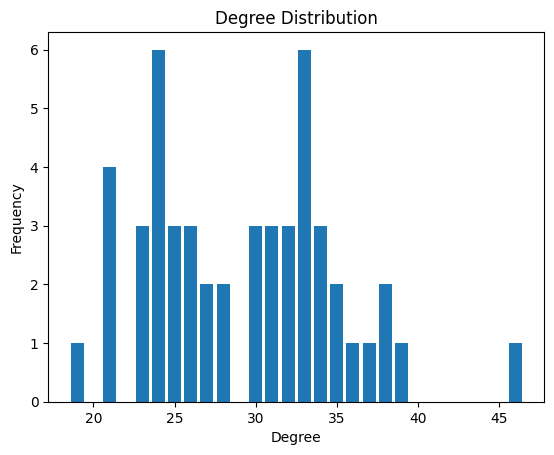

In [13]:
degrees = [deg for node, deg in G.degree()]

# To get the distribution, you can use the collections.Counter class
import collections
degree_distribution = collections.Counter(degrees)

plt.bar(degree_distribution.keys(), degree_distribution.values())
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

In [68]:
combos = {}

for i in range(50):
    for j in range(i, 50):
        if i != j:
            combos[(i,j)] = 0

In [70]:
in_between_count = 0

for source_node, target_node in d.edge_index.t().tolist():
    source_cluster = nodes_to_clusters[source_node]
    target_cluster = nodes_to_clusters[target_node]
    if source_cluster != target_cluster:
        combos[(min(source_cluster, target_cluster), max(source_cluster, target_cluster))] += 1

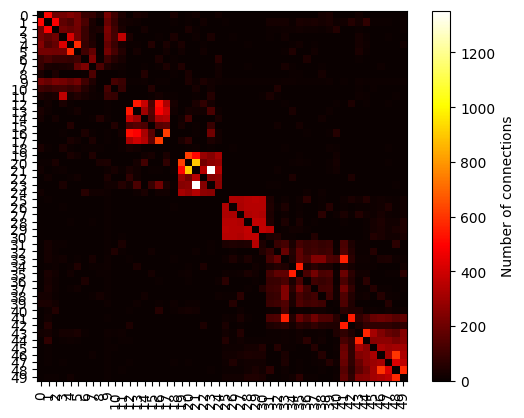

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'd' is your dictionary
keys = combos.keys()
values = combos.values()

# Get the unique cluster IDs
clusters = sorted(set([key[0] for key in keys] + [key[1] for key in keys]))

# Create a DataFrame filled with zeros
df = pd.DataFrame(0, index=clusters, columns=clusters)

# Fill the DataFrame with the values from the dictionary
for (cluster1, cluster2), value in zip(keys, values):
    df.loc[cluster1, cluster2] = value
    df.loc[cluster2, cluster1] = value  # If the connections are bidirectional

# Create a heatmap
plt.imshow(df, cmap='hot', interpolation='nearest')
plt.colorbar(label='Number of connections')
plt.xticks(np.arange(len(clusters)), clusters, rotation=90)
plt.yticks(np.arange(len(clusters)), clusters)
plt.show()

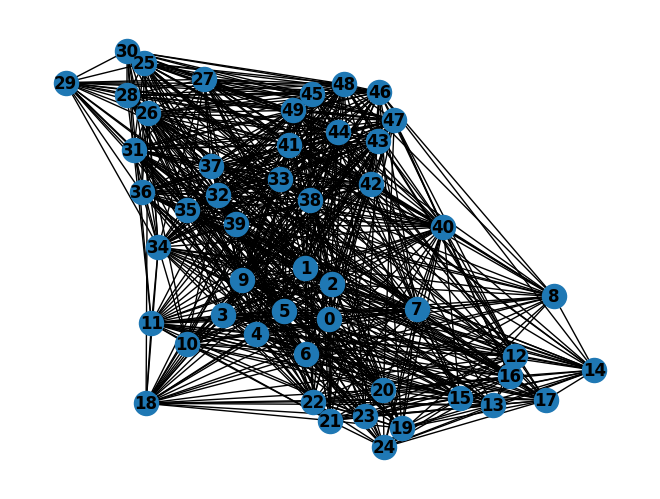

In [78]:
nx.draw(G, with_labels=True, font_weight='bold')

In [2]:
from batching import Batcher
from load import load_cache

data = load_cache()
data = data[0]

In [4]:
from torch_geometric.loader import ClusterData

In [11]:
cluster_data = ClusterData(data, num_parts=10, recursive=False, log=False)

ImportError: 'ClusterData' requires either 'pyg-lib' or 'torch-sparse'

In [3]:
from tqdm import tqdm

for i in tqdm(range(5)):
    print(i)

100%|██████████| 5/5 [00:00<?, ?it/s]

0
1
2
3
4


In [102]:
batcher = Batcher(3, method="fm", as_graph=True)
graphs = batcher(data)

In [203]:
partitions = nx.community.k_clique_communities(G, 30)
cliques = list(partitions)

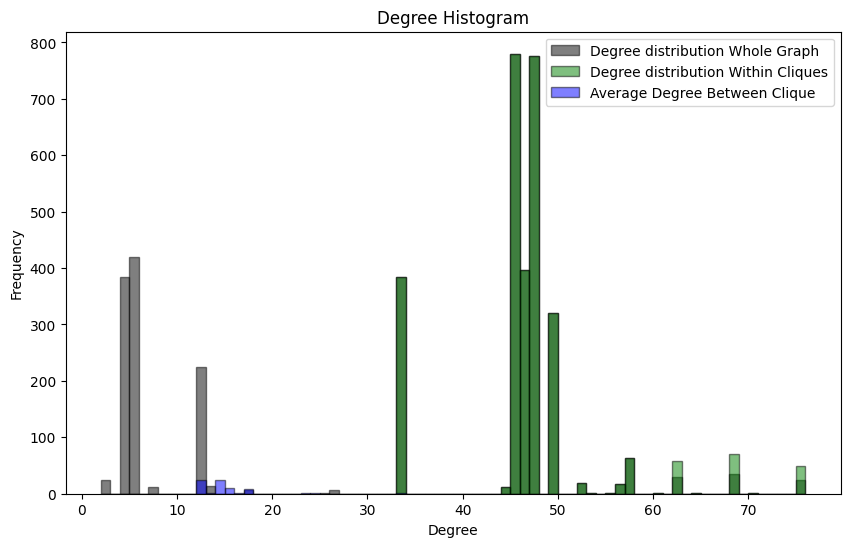

In [157]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence

fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1), color="black", edgecolor='black',alpha=0.5, label="Degree distribution Whole Graph")

import itertools

# Flatten the list of cliques into a single list of nodes
all_nodes = list(itertools.chain.from_iterable(cliques))

# Get the degrees of all nodes
all_degrees = [G.degree(n) for n in all_nodes]

# Create a histogram of the degrees
plt.hist(all_degrees, bins=range(min(degree_sequence), max(degree_sequence) + 1), color="green", edgecolor='black', alpha=0.5, label="Degree distribution Within Cliques")


# Initialize a list to store the average degrees of the cliques
clique_avg_degrees = []

# For each clique
for clique in cliques:
    # Convert the clique to a set for faster membership tests
    clique_set = set(clique)

    # Initialize a counter for the number of edges to different cliques
    count = 0

    # For each node in the clique
    for node in clique:
        # For each neighbor of the node
        for neighbor in G.neighbors(node):
            # If the neighbor is not in the same clique
            if neighbor not in clique_set:
                # Increment the counter
                count += 1

    # Calculate the average degree of the clique and add it to the list
    clique_avg_degrees.append(count / len(clique))

# Create a histogram of the average clique degrees
plt.hist(clique_avg_degrees, bins=range(min(degree_sequence), max(degree_sequence) + 1), color="blue", edgecolor='black', alpha=0.5, label="Average Degree Between Clique")

plt.legend()


plt.title("Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("Degree")
# ax.set_xticks([d + 0.5 for d in range(min(degree_sequence), max(degree_sequence) + 1)])  # Adjust the x-ticks
# ax.set_xticklabels(range(min(degree_sequence), max(degree_sequence) + 1), rotation=90, fontsize='small')  # Rotate the labels and use a smaller font size

plt.show()

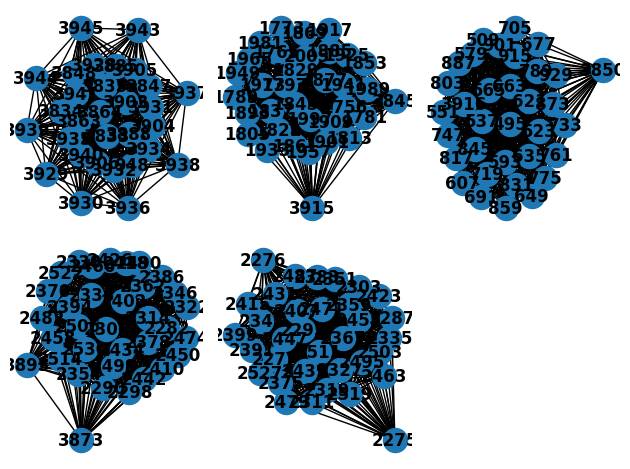

In [160]:
import random
# turn each clique into a graph
clique_graphs = [G.subgraph(clique) for clique in cliques]
# Select a random sample of cliques
sample_cliques = random.sample(clique_graphs, k=5)

# Create a new figure
plt.figure()

# Draw each clique graph
for i, clique_graph in enumerate(sample_cliques):
    plt.subplot(2, 3, i+1)
    nx.draw(clique_graph, with_labels=True, font_weight='bold')

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [161]:
def calculate_overlap(cliques):
    total_overlap = 0
    total_pairs = 0
    
    for i in range(len(cliques)):
        for j in range(i+1, len(cliques)):
            clique1 = set(cliques[i])
            clique2 = set(cliques[j])
            overlap = len(clique1.intersection(clique2))
            total_overlap += overlap
            total_pairs += 1
    
    percent_overlap = (total_overlap / total_pairs) * 100
    return percent_overlap

overlap_percent = calculate_overlap(cliques)
print(f"The percent of overlap between cliques is: {overlap_percent}%")


The percent of overlap between cliques is: 2.405773857257418%


Number of edges between clique 1 and clique 2: 1
Number of edges between clique 1 and clique 3: 1
Number of edges between clique 1 and clique 4: 1
Number of edges between clique 1 and clique 5: 1
Number of edges between clique 1 and clique 6: 1
Number of edges between clique 1 and clique 7: 1
Number of edges between clique 1 and clique 8: 1
Number of edges between clique 1 and clique 9: 1
Number of edges between clique 1 and clique 10: 1
Number of edges between clique 1 and clique 11: 1
Number of edges between clique 1 and clique 12: 1
Number of edges between clique 1 and clique 13: 0
Number of edges between clique 1 and clique 14: 0
Number of edges between clique 1 and clique 15: 0
Number of edges between clique 1 and clique 16: 0
Number of edges between clique 1 and clique 17: 0
Number of edges between clique 1 and clique 18: 0
Number of edges between clique 1 and clique 19: 0
Number of edges between clique 1 and clique 20: 0
Number of edges between clique 1 and clique 21: 0
Number o

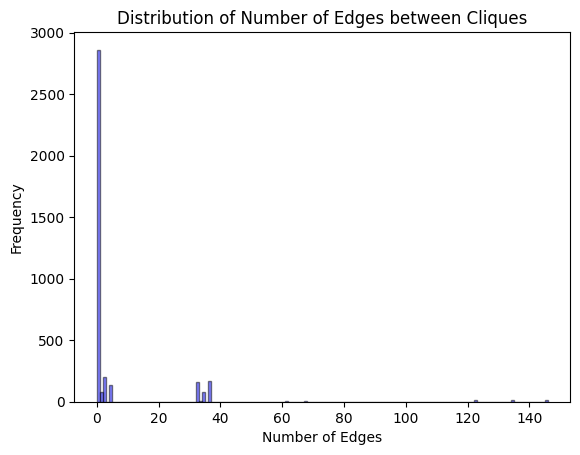

In [169]:
def count_edges_between_cliques(G, clique1, clique2):
    count = 0
    for node1 in clique1:
        for node2 in clique2:
            if G.has_edge(node1, node2):
                count += 1
    return count

# Iterate over all pairs of cliques
for i in range(len(cliques)):
    for j in range(i+1, len(cliques)):
        clique1 = cliques[i]
        clique2 = cliques[j]
        edge_count = count_edges_between_cliques(G, clique1, clique2)
        print(f"Number of edges between clique {i+1} and clique {j+1}: {edge_count}")

import matplotlib.pyplot as plt

# Create an empty list to store the edge counts
edge_counts = []

# Iterate over all pairs of cliques
for i in range(len(cliques)):
    for j in range(i+1, len(cliques)):
        clique1 = cliques[i]
        clique2 = cliques[j]
        edge_count = count_edges_between_cliques(G, clique1, clique2)
        edge_counts.append(edge_count)

# Plot the distribution of edge counts
plt.hist(edge_counts, bins=range(min(edge_counts), max(edge_counts) + 1), color="blue", edgecolor='black', alpha=0.5)
plt.title("Distribution of Number of Edges between Cliques")
plt.xlabel("Number of Edges")
plt.ylabel("Frequency")
plt.show()


In [7]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Batch

data.x = data.x.float()  # Convert node features to float
data.y = data.y.float()
mean = data.x.mean(dim=0, keepdim=True)
std = data.x.std(dim=0, keepdim=True)
data.x = (data.x - mean) / std

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 1)  # Change the output layer to have one output neuron

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, p=0.5, train=self.training)
        x = self.conv2(x, edge_index)

        return x

def train_gcn(model, data, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()  # Change the loss function to MSE


    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        print(f"Epoch {epoch} Model Loss: {loss.item()}")
        loss.backward()
        optimizer.step()


from torch_geometric.utils import from_networkx

def train_gcn_with_cliques(model, G, data, k, batch_size, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()

    G = to_networkx(data, to_undirected=True)

    # Generate k-cliques from the graph
    cliques = list(nx.algorithms.community.k_clique_communities(G, k))

    # Convert cliques to Data objects
    data_list = []
    for clique in cliques:
        nodes = list(clique)
        subgraph = G.subgraph(nodes)
        clique_data = from_networkx(subgraph)
        clique_data.x = data.x[nodes]
        clique_data.y = data.y[nodes]
        data_list.append(clique_data)

    # Create a DataLoader for batching
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)  # Compute loss on the batch
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} Model Loss: {loss.item()}")
    
    

In [8]:
# Initialize the model
model = GCN(4)

# Train the model with cliques
train_gcn_with_cliques(model, G, data, k=30, batch_size=3, epochs=500)

c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([102])) that is different to the input size (torch.Size([102, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a targe

Epoch 0 Model Loss: 641.4845581054688
Epoch 1 Model Loss: 487.8974304199219


c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([98])) that is different to the input size (torch.Size([98, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([103])) that is different to the input size (torch.Size([103, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2 Model Loss: 118.2271499633789
Epoch 3 Model Loss: 119.01052856445312
Epoch 4 Model Loss: 40.19883728027344
Epoch 5 Model Loss: 30.9528751373291
Epoch 6 Model Loss: 35.64686965942383
Epoch 7 Model Loss: 9.241814613342285
Epoch 8 Model Loss: 19.874013900756836
Epoch 9 Model Loss: 11.97757625579834
Epoch 10 Model Loss: 39.87156295776367
Epoch 11 Model Loss: 15.824040412902832


c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12 Model Loss: 13.381941795349121
Epoch 13 Model Loss: 13.794539451599121
Epoch 14 Model Loss: 9.416614532470703
Epoch 15 Model Loss: 45.845436096191406
Epoch 16 Model Loss: 22.87882423400879
Epoch 17 Model Loss: 15.419797897338867
Epoch 18 Model Loss: 33.36951446533203
Epoch 19 Model Loss: 43.21926498413086
Epoch 20 Model Loss: 23.480363845825195
Epoch 21 Model Loss: 11.462952613830566


c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22 Model Loss: 18.647354125976562
Epoch 23 Model Loss: 13.226883888244629
Epoch 24 Model Loss: 14.107780456542969
Epoch 25 Model Loss: 11.538326263427734
Epoch 26 Model Loss: 14.29683780670166
Epoch 27 Model Loss: 15.7727689743042
Epoch 28 Model Loss: 10.5639066696167
Epoch 29 Model Loss: 14.465971946716309
Epoch 30 Model Loss: 27.044965744018555
Epoch 31 Model Loss: 36.122798919677734
Epoch 32 Model Loss: 17.719894409179688
Epoch 33 Model Loss: 10.685677528381348
Epoch 34 Model Loss: 14.913287162780762
Epoch 35 Model Loss: 43.48656463623047
Epoch 36 Model Loss: 13.939239501953125
Epoch 37 Model Loss: 29.65533447265625


c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([108])) that is different to the input size (torch.Size([108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 38 Model Loss: 14.15488338470459
Epoch 39 Model Loss: 16.25624656677246
Epoch 40 Model Loss: 12.738706588745117
Epoch 41 Model Loss: 12.819594383239746
Epoch 42 Model Loss: 8.800521850585938
Epoch 43 Model Loss: 16.69158363342285
Epoch 44 Model Loss: 15.844921112060547
Epoch 45 Model Loss: 17.067092895507812
Epoch 46 Model Loss: 57.92070770263672
Epoch 47 Model Loss: 31.02140998840332
Epoch 48 Model Loss: 31.25944709777832
Epoch 49 Model Loss: 42.886775970458984
Epoch 50 Model Loss: 26.16931915283203
Epoch 51 Model Loss: 16.260374069213867
Epoch 52 Model Loss: 51.885135650634766
Epoch 53 Model Loss: 15.241539001464844
Epoch 54 Model Loss: 15.506247520446777
Epoch 55 Model Loss: 31.966764450073242
Epoch 56 Model Loss: 15.462701797485352
Epoch 57 Model Loss: 18.07139778137207
Epoch 58 Model Loss: 15.212309837341309
Epoch 59 Model Loss: 16.056859970092773
Epoch 60 Model Loss: 11.436991691589355
Epoch 61 Model Loss: 12.886873245239258


c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([106])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 62 Model Loss: 39.32228469848633
Epoch 63 Model Loss: 15.501042366027832
Epoch 64 Model Loss: 44.10960388183594
Epoch 65 Model Loss: 38.75447082519531
Epoch 66 Model Loss: 15.940186500549316
Epoch 67 Model Loss: 32.43375015258789
Epoch 68 Model Loss: 11.024953842163086
Epoch 69 Model Loss: 16.22113609313965
Epoch 70 Model Loss: 14.274569511413574
Epoch 71 Model Loss: 9.99594783782959
Epoch 72 Model Loss: 18.23392677307129
Epoch 73 Model Loss: 10.225598335266113
Epoch 74 Model Loss: 25.5999698638916


KeyboardInterrupt: 

In [259]:
def baseline_model(train_data, test_data):
    # Compute the mean of the training data
    train_mean = train_data.y.mean()

    # Create a baseline prediction array filled with the mean of the training data
    baseline_predictions = np.full(shape=test_data.y.shape, fill_value=train_mean)

    return mean_squared_error(test_data.y, baseline_predictions)

baseline_model(data, new_data)

20.443186

In [269]:
from torch.nn.functional import cosine_similarity

In [263]:
# Load the new dataset
new_data = load_data(2)
new_data.x = new_data.x.float()
new_data.y = new_data.y.float()
mean = new_data.x.mean(dim=0, keepdim=True)
std = new_data.x.std(dim=0, keepdim=True)
new_data.x = (new_data.x - mean) / std

# Convert the new dataset to a torch_geometric.data.Data object
# This step depends on the format of your new_data and the requirements of your model

# Pass the new dataset through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(new_data)

# Compare the predictions with the true labels
# This step depends on the task (classification, regression, etc.) and the performance metric (accuracy, MSE, etc.)
from sklearn.metrics import mean_squared_error

# Assuming `predictions` and `actual` are your predicted and actual values
mse = mean_squared_error(new_data.y, predictions)

mse

61.78627

In [9]:
import time

# Initialize the model
model = GCN(4)

# Train the model without cliques and measure the time
start_time = time.time()
train_gcn(model, data, epochs=2000)
end_time = time.time()
print(f"Training time without cliques: {end_time - start_time} seconds")

c:\Users\spenc\dev\venv\dsc180\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3952])) that is different to the input size (torch.Size([3952, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Model Loss: 658.83154296875
Epoch 1 Model Loss: 658.8758544921875
Epoch 2 Model Loss: 657.97119140625
Epoch 3 Model Loss: 657.601806640625
Epoch 4 Model Loss: 657.2881469726562
Epoch 5 Model Loss: 656.8773803710938
Epoch 6 Model Loss: 657.0092163085938
Epoch 7 Model Loss: 656.0790405273438
Epoch 8 Model Loss: 655.759765625
Epoch 9 Model Loss: 655.8936767578125
Epoch 10 Model Loss: 655.4207763671875
Epoch 11 Model Loss: 654.9391479492188
Epoch 12 Model Loss: 654.732666015625
Epoch 13 Model Loss: 654.615478515625
Epoch 14 Model Loss: 654.4219360351562
Epoch 15 Model Loss: 653.5592041015625
Epoch 16 Model Loss: 653.583740234375
Epoch 17 Model Loss: 653.3657836914062
Epoch 18 Model Loss: 652.52197265625
Epoch 19 Model Loss: 652.5098876953125
Epoch 20 Model Loss: 651.9036254882812
Epoch 21 Model Loss: 651.336669921875
Epoch 22 Model Loss: 651.4061889648438
Epoch 23 Model Loss: 650.4618530273438
Epoch 24 Model Loss: 649.8933715820312
Epoch 25 Model Loss: 650.1964111328125
Epoch 26 Mo

KeyboardInterrupt: 

In [ ]:
def num_between_links(G, groups):
    num_between_links_list = []
    
    for group in groups:
        num_between_links = 0
        for i in range(len(group)):
            for j in range(i+1, len(group)):
                if G.has_edge(group[i], group[j]):
                    num_between_links += 1
        num_between_links_list.append(num_between_links)
    
    return num_between_links_list

def sample_groups(G, q, rw=False):
    nodes = list(G.nodes())
    groups = []
    while len(nodes) > 0:
        if len(nodes) < q:
            group = nodes
        else:
            if rw:
                group = random_walk(nodes, q)
            else:
                group = np.random.choice(nodes, q, replace=False)
        nodes = [n for n in nodes if n not in group]
        groups.append(group)
    return groups

def random_walk(nodes, q):
    # Start at a random node
    node = np.random.choice(list(nodes))
    subgraph = G.subgraph(nodes)
    walk = [node]

    # Perform the random walk
    for _ in range(q - 1):
        neighbors = [n for n in subgraph.neighbors(node) if n not in walk]
        if neighbors:
            node = np.random.choice(neighbors)
            walk.append(node)
        else:
            break

    return walk

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

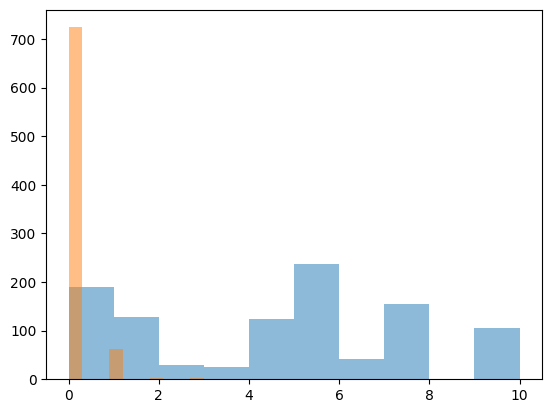

In [ ]:
# Generate data for rw=True
between_link_data_true = [num_between_links(G, sample_groups(G, 5, rw=True)) for _ in range(1)]
between_link_data_true = [item for sublist in between_link_data_true for item in sublist]

# Generate data for rw=False
between_link_data_false = [num_between_links(G, sample_groups(G, 5, rw=False)) for _ in range(1)]
between_link_data_false = [item for sublist in between_link_data_false for item in sublist]

# Plot on the i-th subplot
plt.hist(between_link_data_true, alpha=0.5, label='rw=True')
plt.hist(between_link_data_false, alpha=0.5, label='rw=False')

plt.set_title(f'Histogram for q={5}')  # Set the title of the i-th subplot
plt.legend()  # Add a legend to the i-th subplot

plt.show()

As we can see for reasonably sized q, the number of between links we actually see within a batch is skewed right. This means that even though we try aggregating different clusters together into a batch so we can capture between cluster edges, the number of times we see these relationship is low.

I try increasing the probability by using random walk sampling treating the clusters as part of their own graph rather than simply random sampling

In [ ]:
from load import load_data

data = load_data(1)

In [ ]:
connectivity_data = np.load('../data/xbar/1/xbar_connectivity.npz')

In [ ]:
set(connectivity_data['data'])

{1, 2, 3, 4, 5, 6}

In [10]:
import matplotlib.pyplot as plt

def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

def print_bst(bst, indent=0):
    value, left, right = bst
    print(' ' * indent + str(value))
    if isinstance(left, tuple):
        print_bst(left, indent + 2)
    else:
        print(' ' * (indent + 2) + str(left))
    if isinstance(right, tuple):
        print_bst(right, indent + 2)
    else:
        print(' ' * (indent + 2) + str(right))


congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])

def draw_bst(bst, parent=None, pos={}, x=0, y=0, dx=1, dy=1):
    value, left, right = bst
    pos[value] = (x, y)
    G.add_node(value)
    if parent is not None:
        G.add_edge(parent, value)
    if isinstance(left, tuple):
        pos, x, y = draw_bst(left, value, pos, x-dx, y-dy, dx/2, dy)
    if isinstance(right, tuple):
        pos, x, y = draw_bst(right, value, pos, x+dx, y-dy, dx/2, dy)
    return pos, x, y

G = nx.DiGraph()
pos, _, _ = draw_bst(xbst)
nx.draw(G, pos, with_labels=True, arrows=False, node_size=22, font_size=8)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
with gzip.open(f'../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])

def getGRCIndex(x,y,xbst,ybst):
            while (type(xbst)==tuple):
                if x < xbst[0]:
                    xbst=xbst[1]
                else:
                    xbst=xbst[2]
                    
            while (type(ybst)==tuple):
                if y < ybst[0]:
                    ybst=ybst[1]
                else:
                    ybst=ybst[2]
                    
            return ybst, xbst

demand = np.zeros(shape = [instances.shape[0],])


for k in range(instances.shape[0]):
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
                
instances['routing_demand'] = demand

In [ ]:
def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
plt.figure()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('coolwarm')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5, edgecolor='black', linewidth=0.5)
# Display the plot
plt.show()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('hot')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['RuntimeError: Could not locate METIS dll. Please set the METIS_DLL environment variable to its full path.yloc'], color=cmap(normalized_demand), s=5)
# Display the plot
plt.show()

C:\Users\spenc\AppData\Local\Temp\ipykernel_9404\1212054739.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


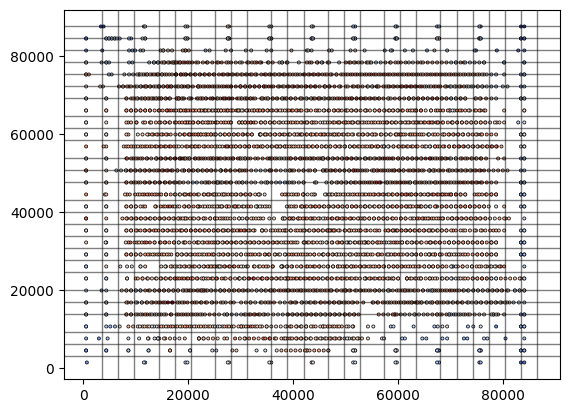

C:\Users\spenc\AppData\Local\Temp\ipykernel_9404\1212054739.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hot')


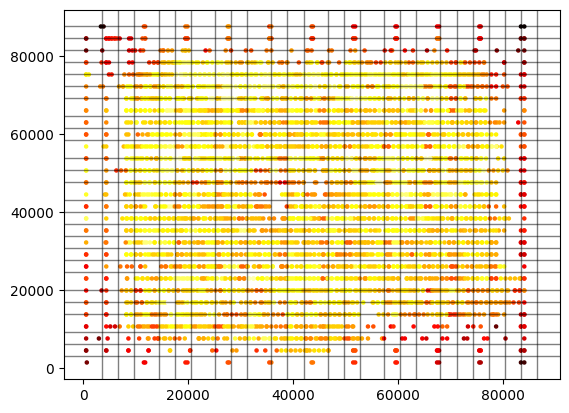

In [ ]:
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
plt.figure()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('coolwarm')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5, edgecolor='black', linewidth=0.5)
# Display the plot
plt.show()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('hot')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5)
# Display the plot
plt.show()